# Prolexitim Visualization (Prolexitim Viz)
## t-SNE and PCA 2D Visualization of narratives
### Dataset from Prolexitim TAS-20 Spain, Prolexitim NLP and Spanish 3Billion Word2Vec
<hr>
Sept 2019.<br> Prolexitim dataset version 1.2 (MPGS-TFM-Submission).<br> 
Raúl Arrabales Moreno (Psicobótica / Serendeepia Research)<br>
<a target="_blank" href="http://www.conscious-robots.com/">http://www.conscious-robots.com/</a> <br>
<hr>
Spanish Word Vectors from: <a taget="_blank" href="https://github.com/aitoralmeida/spanish_word2vec">Spanish 3B Pre-trained Word2Vec</a>

## Load Word Vectors and Documents (texts + labels)
- Word Vectors are obtained from the pre-trained Spanish 3B Word2Vec.
- Documents are obtained from the Prolexitim Pilot Study.
    - Text are narratives from Prolexitim NLP. 
    - Labels are categorical values from Prolexitim TAS-20.


### Loading the word vectors

In [1]:
from gensim.models import KeyedVectors

In [2]:
# My copy of Spanish 3 Billion Word2Vec
word_vectors = KeyedVectors.load('D:\Dropbox-Array2001\Dropbox\DataSets\Spanish Word2Vec\complete.kv', mmap='r')

In [3]:
# Testing Word Vectors for Spanish
word_vectors.most_similar("niño")

[('chiquillo', 0.863490104675293),
 ('bebé', 0.85056471824646),
 ('crío', 0.842483401298523),
 ('muchacho', 0.7765985727310181),
 ('niñito', 0.7588649988174438),
 ('chico', 0.75837242603302),
 ('cachorro', 0.7369438409805298),
 ('muchachito', 0.7227176427841187),
 ('gatito', 0.6718686819076538),
 ('hombre', 0.6658662557601929)]

In [108]:
# Testing Word Vectors for Spanish
# word_vectors.get_vector("niño")

In [110]:
# Testing Word Vectors for Spanish
word_vectors.similar_by_vector(
    word_vectors.get_vector("rey") - 
    word_vectors.get_vector("hombre") + 
    word_vectors.get_vector("mujer"))

[('reina', 0.7074883580207825),
 ('princesa', 0.6571577787399292),
 ('emperatriz', 0.6183611750602722),
 ('esposa', 0.5992065072059631),
 ('doncella', 0.5958696603775024),
 ('dama', 0.5885563492774963),
 ('infanta', 0.5775144696235657),
 ('mujer', 0.5741763114929199),
 ('concubina', 0.5553327202796936),
 ('hija', 0.5514962673187256)]

### Loading Prolexitim TAS-20 + NLP Dataset Load

In [6]:
import pandas as pd 

In [111]:
# My copy of Prolexitim join tables with TAS-20 categorical label and narratives from Prolexitim NLP
tasnlp_dataset_path = "D:\\Dropbox-Array2001\\Dropbox\\UNI\\MPGS\\2_TFM\\Datos\\prolexitim-merged-1.3.csv"

In [112]:
docs_df = pd.read_csv(tasnlp_dataset_path,header=0,delimiter="\t")

In [113]:
# We're only intereted in the Spanish text and the corresponding Alexithymia label
docs_df = docs_df.dropna()
docs_df = docs_df[['Text', 'alex-a']]
docs_df.columns = ['Text', 'AlexLabel']
docs_df.sample(n=6)

,Text,AlexLabel
179,un grupo de amigos que les gustaban las aventu...,PosAlex
36,Le acaban de dar una noticia muy mala porque l...,NoAlex
21,Esto es una señora que le acaban de dar una ma...,NoAlex
113,"un hombre y una mujer, puede que la mujer esté...",PosAlex
25,A mí me recuerda a los chavales cuando no sabí...,NoAlex
237,despertando después de hacer el amor con una b...,Alex


In [114]:
# As expected, we have a very unbalance dataset (aprox 10% alexithymia)
docs_df.groupby(by='AlexLabel').count()

,Text
AlexLabel,
Alex,31
NoAlex,240
PosAlex,45


In [115]:
# And we decided to consider both Possible Alexithymia and Alexithymia as the same (Positive) class
docs_df['AlexLabel'] = docs_df['AlexLabel'].apply(lambda x: x.replace('PosAlex', 'Alex'))

In [116]:
docs_df.groupby(by='AlexLabel').count()

,Text
AlexLabel,
Alex,76
NoAlex,240


In [117]:
docs_df.shape

(316, 2)

# Feature vectors using Pre-trained Spanish Word Embeddings

## Vectorizers for documents (narratives) - Doc2Vec
Using existing word embeddings for Spanish we obtain a vector for each word. 
We also need to build a single vector representing the entire document, and for that we use different methods 

In [118]:
import numpy as np

In [119]:
# Calculates the mean word vector of a list of words using the indicated word2vec model
def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in word2vec_model.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return []

In [120]:
# docs_df.get_values()[1][0]

'Una madre que está consolando a su hijo, después de darle las notas, que ha sacado no sé cuantos insuficientes'

In [30]:
# get_mean_vector( word_vectors, docs_df.get_values()[1][0].split() ) 

## Converting texts into 400-dimensional vecs

In [121]:
docs_df['Text'] = docs_df['Text'].apply(lambda x: get_mean_vector(word_vectors, x.split()))

In [122]:
docs_df['Text'].shape[0]

316

In [124]:
docs_df.sample(2)

,Text,AlexLabel
33,"[0.07857421, -0.49665523, -1.133586, 0.0082593...",NoAlex
118,"[-0.4983944, -0.91248834, -0.38407347, 0.42629...",NoAlex


## Preparing data for visualization

In [125]:
# Name the new columns for features 
# Xi are the Doc2Vec dimensions
feat_cols = [ 'X-'+str(i) for i in range(word_vectors.vector_size) ]

In [126]:
# Add Xi to a new dataframe as columns
df = pd.DataFrame(np.column_stack(list(zip(*docs_df['Text'].get_values()))), columns=feat_cols)
df.shape

(316, 400)

In [128]:
# Add the label to the df as a new column
df['y'] = docs_df['AlexLabel'].get_values()
df.shape

(316, 401)

In [131]:
df.sample(4)

,X-0,X-1,X-2,X-3,X-4,X-5,X-6,X-7,X-8,X-9,...,X-391,X-392,X-393,X-394,X-395,X-396,X-397,X-398,X-399,y
255,1.118459,-0.363183,-2.325202,-1.498535,0.449706,-0.432613,-0.601883,-0.270360,1.264371,-0.323065,...,0.832332,-0.344631,-0.311708,-1.302373,-3.306339,-0.862088,2.111035,1.493838,-1.885173,NoAlex
223,0.191317,0.561498,-0.743412,-0.504792,1.581110,-0.614235,0.256454,-0.327123,-0.193037,-0.594747,...,0.938761,-0.784671,0.804589,-0.994943,-1.165016,-1.441822,0.372391,1.620864,-0.388592,Alex
170,0.689235,-0.774325,-0.404031,0.022976,0.994053,-1.105081,0.029822,0.675584,0.599592,0.388542,...,-0.078972,0.708426,0.273631,-0.015515,-0.469885,0.131283,1.087900,0.112537,-0.448603,NoAlex
314,-0.087938,-0.941084,-0.409083,0.218923,1.114106,-0.670373,-0.645470,0.304526,0.332099,0.526869,...,-0.389154,-0.014353,0.841415,-0.271603,-0.742122,0.145704,0.987741,0.722008,0.345696,Alex


In [132]:
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (316, 401)


## Using PCA to project into a 2D space

In [137]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feat_cols].values)

In [139]:
df['pca-1'] = pca_result[:,0]
df['pca-2'] = pca_result[:,1]

In [140]:
df.sample(4)

,X-0,X-1,X-2,X-3,X-4,X-5,X-6,X-7,X-8,X-9,...,X-393,X-394,X-395,X-396,X-397,X-398,X-399,y,pca-1,pca-2
151,-0.306138,-0.128466,-0.602213,0.051811,0.722613,-0.543894,-0.406675,-0.636734,0.212714,0.389784,...,-0.114097,-1.081081,-0.918725,-0.460545,0.304387,1.204008,0.252737,NoAlex,-3.901942,3.894003
94,-0.058325,-0.994232,-0.707467,-0.044605,0.829481,-0.524377,-0.178582,0.183523,0.323801,0.061337,...,0.094312,-0.288437,-0.193157,0.813131,0.818633,-0.076100,0.533259,NoAlex,7.605083,3.885520
230,0.221559,-0.469617,-0.679500,-0.383782,0.749529,-0.455118,-0.727191,-0.480802,0.412790,0.329623,...,-0.082100,-1.038516,-0.941084,-1.007755,1.347143,1.349607,-0.032709,NoAlex,-4.441039,4.942625
197,-0.007119,-0.735285,-0.396098,0.066176,0.994440,-0.539137,0.212514,-0.164372,0.075474,-0.150516,...,0.152557,-0.758594,-0.972938,0.515245,0.264331,0.968958,0.408967,NoAlex,3.234218,1.133538


In [141]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.20713027 0.07029649]


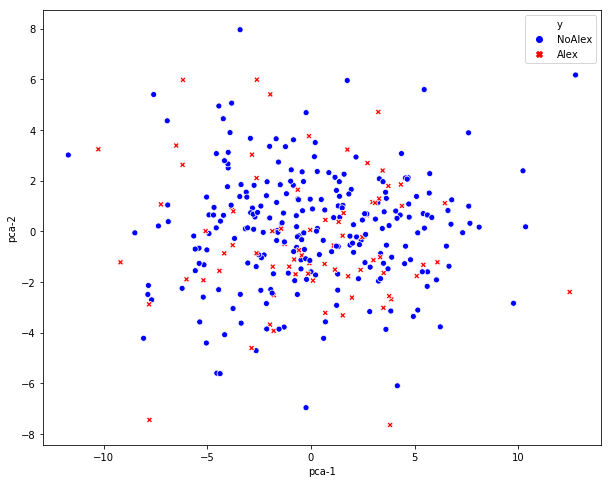

In [166]:
plt.figure(figsize=(10,8))
markers = {"Alex": "X", "NoAlex": "o"}
sns.scatterplot(
    x="pca-1", 
    y="pca-2",
    hue="y",
    style="y",
    palette=sns.color_palette(["#0000ff", "#ff0000"]),
    data=df,
    markers=markers,
    legend="full",
    alpha=1
)

## Using PCA to project into a 3D space

In [155]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

In [156]:
df['pca-1'] = pca_result[:,0]
df['pca-2'] = pca_result[:,1]
df['pca-3'] = pca_result[:,2]

In [157]:
df.sample(4)

,X-0,X-1,X-2,X-3,X-4,X-5,X-6,X-7,X-8,X-9,...,X-394,X-395,X-396,X-397,X-398,X-399,y,pca-1,pca-2,pca-3
110,-0.151910,-1.050460,-1.137015,0.293178,0.444000,-0.855390,0.177459,0.065164,0.424514,-0.435053,...,0.018375,-0.255102,0.344060,0.889195,1.026724,0.212306,Alex,3.514068,-1.641873,-1.658318
244,-0.128132,-0.481466,-0.270343,-0.135993,0.748241,-0.665462,0.861111,-0.954201,0.533073,-0.738764,...,-0.101716,-1.470184,0.101365,0.405679,1.939866,0.063763,NoAlex,-1.808028,-1.676344,-2.973947
98,-0.123455,-0.614725,-1.067672,0.141310,0.809279,-0.296878,0.260216,-0.427128,0.013758,0.532020,...,-0.299062,-1.015238,-0.261029,0.751129,1.312050,0.209572,NoAlex,-0.252529,-1.082437,-0.162945
118,-0.271627,-0.952217,-0.640624,0.007386,0.661505,-0.630952,0.489910,-0.097749,-0.133254,-0.285852,...,-0.613913,-0.819587,-0.245787,0.316487,1.602795,0.733004,NoAlex,1.291473,-1.684122,2.468693


In [158]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.2071303  0.07029647 0.0658333 ]


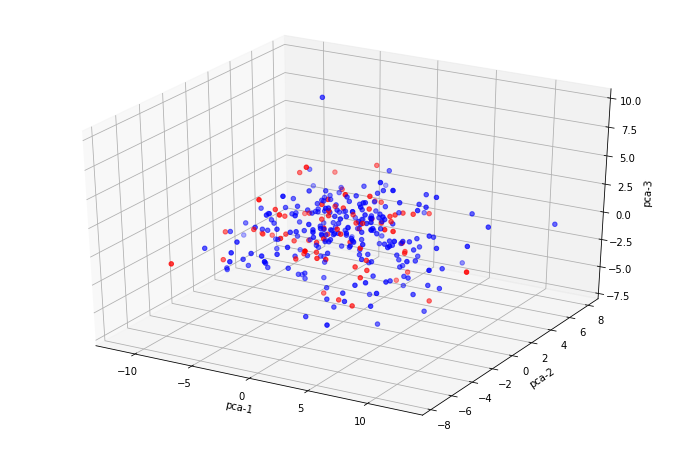

In [161]:
colors = {'Alex':'red', 'NoAlex':'blue'}
ax = plt.figure(figsize=(12,8)).gca(projection='3d')
ax.scatter(
    xs=df["pca-1"], 
    ys=df["pca-2"], 
    zs=df["pca-3"], 
    c=df['y'].apply(lambda x: colors[x])
)
ax.set_xlabel('pca-1')
ax.set_ylabel('pca-2')
ax.set_zlabel('pca-3')
plt.show()

## Using t-SNE to project into a 2D space

In [162]:
data = df[feat_cols].values

In [163]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 316 samples in 0.004s...
[t-SNE] Computed neighbors for 316 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 316 / 316
[t-SNE] Mean sigma: 3.089098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.363106
[t-SNE] KL divergence after 300 iterations: 1.233669


In [164]:
df['tsne-2d-1'] = tsne_results[:,0]
df['tsne-2d-2'] = tsne_results[:,1]

In [165]:
df.sample(4)

,X-0,X-1,X-2,X-3,X-4,X-5,X-6,X-7,X-8,X-9,...,X-396,X-397,X-398,X-399,y,pca-1,pca-2,pca-3,tsne-2d-1,tsne-2d-2
191,-0.134536,-0.857307,-0.557955,-0.142064,0.779675,-0.973493,0.250363,-0.118114,-0.094059,-0.447118,...,-0.460763,0.469324,1.806160,0.483093,NoAlex,-0.051327,-1.150025,0.096102,-1.108321,-3.481961
146,-0.188305,-1.092564,-0.955071,0.170896,0.647327,-0.531403,0.487089,-0.020619,-0.186025,-0.388185,...,0.726952,0.140377,0.937962,0.565395,Alex,6.104549,-1.221066,1.058107,8.850558,11.144759
49,0.194154,-0.802226,-1.134616,0.295151,1.033297,-0.936962,-0.064561,0.679462,-0.237932,-0.010541,...,0.387272,0.753963,0.673369,0.337256,NoAlex,4.566782,-0.586961,-2.972641,10.867945,14.706865
133,0.862909,-1.042678,-0.781047,-0.050212,1.429064,-0.276617,0.085690,0.006255,-0.075972,-0.441603,...,0.370381,0.719575,0.988425,0.316159,NoAlex,2.858772,-1.413379,-0.934036,18.211821,-1.909374


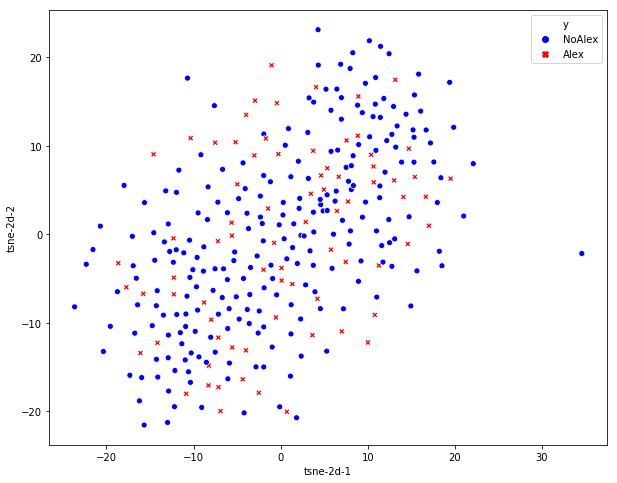

In [167]:
plt.figure(figsize=(10,8))
markers = {"Alex": "X", "NoAlex": "o"}
sns.scatterplot(
    x="tsne-2d-1", 
    y="tsne-2d-2",
    hue="y",
    style="y",
    palette=sns.color_palette(["#0000ff", "#ff0000"]),
    data=df,
    markers=markers,
    legend="full",
    alpha=1
)